In [55]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import logging
logging.basicConfig(level=logging.ERROR) # to avoid the logging bug in natcap.invest
import natcap.invest.coastal_vulnerability.coastal_vulnerability_core as cv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
sns.set(font_scale=1.3)

In [ ]:
# workspace = '../mpa-removeall-habitat/scenario_data/'

### load baseline habitat ranks

In [56]:
# these data built by Jess in GIS - selecting points within the 'protective distance' of each habitat, and assigning rank
# then maybe some manual selection/deselection of points to account for the 'skinny island' effect 
# When building this shapefile, MUST start with 'coastal_exposure.shp' returned by invest
# so that later on habitats ranks can be merged with other exposure indices, by simply binding columns together
allhabitats = gpd.read_file('../mpa-removeall-habitat/habitat_ranks_baseline.shp')

# baseline habitat ranks could also come from CV outputs - coastal_exposure.cv

In [ ]:
allhabitats.head()

### adjust ranks based on HRA scenarios that reduce habitat functionality based on risk
#### find points within protective distance of each habitat, by each habitat risk category, assign new habitat ranks  

In [ ]:
# Load Protective Distances
protection = pd.read_csv('../mpa-removeall-habitat/NaturalHabitat_Bahamaswide.csv')
protection

In [ ]:
# Define habitat rank changes
seagrass_adjust_dict = {'low':4, 'med':4.5, 'high':4.75}
coral_adjust_dict = {'low':1, 'med':2, 'high':3}
pine_adjust_dict = {'low':3, 'med':4, 'high':4.75}
coppice_adjust_dict = {'low':1, 'med':2, 'high':3}
mangrove_adjust_dict = {'low':3, 'med':4, 'high':4.75}

In [ ]:
def subset_buffer_intersect(hra_hab_geodf, base_hab_geodf, buffdist, risk):
    # risk is one of 'LOW' 'MED' or 'HIGH'
    hra_subset = hra_hab_geodf[hra_hab_geodf.CLASSIFY == risk]
#     print(buffdist)
    hra_buf = hra_subset.buffer(buffdist)
    
    inter = base_hab_geodf.intersects(hra_buf.unary_union)
    print(inter.value_counts()) # quick check on how many intersecting points
    
    return(inter)

In [ ]:
def join_hra_risk(hra_risk_shp, protection_distance_df, protection_habstr, baseline_habstr):
    print('joining:  ' + hra_risk_shp)
    hra = gpd.read_file(hra_risk_shp)
    buffdist = protection_distance_df[protection_distance_df.HABITAT == protection_habstr]['PROTECTION DISTANCE (m)']
    
    base_hab = allhabitats[['geometry', baseline_habstr]]
    
    low_inter = subset_buffer_intersect(hra, base_hab, buffdist, 'LOW')
    base_hab['low'] = low_inter
    med_inter = subset_buffer_intersect(hra, base_hab, buffdist, 'MED')
    base_hab['med'] = med_inter
    high_inter = subset_buffer_intersect(hra, base_hab, buffdist, 'HIGH')
    base_hab['high'] = high_inter
    
    return(base_hab)
    

In [ ]:
def adjust_rank(x, baseline_habstr, adjust_dict):
# x : dataframe with baseline habitat rank column and hra risk categories

# can't use this first clause because coral restoration is in the scenario,
# but shouldn't need it anyhow if not dealing with the 'skinny island' problem
#     if x[baseline_habstr] == 0:
#         return(0)
#     else:

# low trumps med trumps high, just so that 'low' risk coral spots in the restoration scenario 
# have an effect
    if x.low:
        return(adjust_dict['low'])
    if x.med:
        return(adjust_dict['med'])
    if x.high:
        return(adjust_dict['high'])
    return(x[baseline_habstr])

In [ ]:
# pick a scenario workspace:
workspace = '../../hra/SWMMA/_250m_3max/output/Maps/'
scenario_str = 'swmma_current'
# workspace = '../../hra/SWMMA/_restoration/'
# scenario_str = 'swmma_restore'

In [ ]:
seagrass = join_hra_risk(os.path.join(workspace, '[seagrass]_RISK.shp'),
          protection, 'Seagrass', 'sgr_rank')
seagrass['new_rank'] = seagrass.apply(axis=1, func=adjust_rank, args=('sgr_rank', seagrass_adjust_dict))

coral = join_hra_risk(os.path.join(workspace, '[coral]_RISK.shp'),
          protection, 'ShallowCoral', 'cor_rank')
coral['new_rank'] = coral.apply(axis=1, func=adjust_rank, args=('cor_rank', coral_adjust_dict))
                      
pine = join_hra_risk(os.path.join(workspace, '[pineland]_RISK.shp'),
          protection, 'Pine', 'pine_rank')
pine['new_rank'] = pine.apply(axis=1, func=adjust_rank, args=('pine_rank', pine_adjust_dict))
                     
coppice = join_hra_risk(os.path.join(workspace, '[coppice]_RISK.shp'),
          protection, 'DenseMangroveandCoppice', 'copp_rank')
coppice['new_rank'] = coppice.apply(axis=1, func=adjust_rank, args=('copp_rank', coppice_adjust_dict))
                        
mangrove = join_hra_risk(os.path.join(workspace, '[mangrove]_RISK.shp'),
          protection, 'SwampSparseMangrove', 'mang_rank')
mangrove['new_rank'] = mangrove.apply(axis=1, func=adjust_rank, args=('mang_rank', mangrove_adjust_dict))
                         
seagrass.shape[0] == coral.shape[0] == pine.shape[0] == coppice.shape[0] == mangrove.shape[0]
                         
new_habranks = pd.concat(
    [seagrass.new_rank, coral.new_rank, pine.new_rank, coppice.new_rank, mangrove.new_rank], axis=1)
new_habranks.columns = ['sgr_rank', 'cor_rank', 'pine_rank', 'copp_rank', 'mang_rank']

new_habranks.to_csv(os.path.join('../swmma-scenarios', scenario_str+'_habitat_ranks.csv'), index=False)

In [ ]:
qaqc_newhab_shp = gpd.GeoDataFrame(new_habranks, geometry=allhabitats.geometry, crs=allhabitats.crs)

In [ ]:
qaqc_newhab_shp.to_file(os.path.join('../swmma-scenarios', scenario_str+'_habitat_ranks.shp'))

In [ ]:
# qaqc
# new_habranks.drop_duplicates()

### compute coastal forest score for baseline and 2 scenario habitat ranks
CF rank for a point is the 'best' rank among the coppice, mangrove, pine habitat ranks present at that point

In [ ]:
# x : dataframe with habitat rank column for each habitat considered for coastal forest
def coastal_forest_rank(x):
    if sum(x) == 0:
        return 0
    else:
        return min(x[x>0])

In [ ]:
base_habitats = gpd.read_file('../mpa-removeall-habitat/habitat_ranks_baseline.shp')
current_habitats = gpd.read_file('../swmma-scenarios/swmma_current_habitat_ranks.shp')
restore_habitats = gpd.read_file('../swmma-scenarios/swmma_restore_habitat_ranks.shp')

In [ ]:
base_habitats['cf_rank'] = \
base_habitats[['copp_rank', 'mang_rank', 'pine_rank']].apply(axis=1, func=coastal_forest_rank)

In [ ]:
current_habitats['cf_rank'] = \
current_habitats[['copp_rank', 'mang_rank', 'pine_rank']].apply(axis=1, func=coastal_forest_rank)

In [ ]:
restore_habitats['cf_rank'] = \
restore_habitats[['copp_rank', 'mang_rank', 'pine_rank']].apply(axis=1, func=coastal_forest_rank)

In [ ]:
# QAQC: results of coastal_forest rank
current_habitats[['copp_rank', 'mang_rank', 'pine_rank', 'cf_rank']].drop_duplicates()

### compute natural_habitats rank

In [ ]:
# x : dataframe with habitat rank column for only the habitats considered
# func follows logic in invest cv model
def recalc_habindex(x):
    if sum(x) == 0:
        return 5
    else:
        x = x[x != 0]
        return cv.combined_rank(x) # imported from invest


In [ ]:
base_habitats['natural_habitats'] = \
base_habitats[['cf_rank', 'sgr_rank', 'cor_rank']].apply(axis=1, func=recalc_habindex)

In [ ]:
current_habitats['natural_habitats'] = \
current_habitats[['cf_rank', 'sgr_rank', 'cor_rank']].apply(axis=1, func=recalc_habindex)

In [ ]:
restore_habitats['natural_habitats'] = \
restore_habitats[['cf_rank', 'sgr_rank', 'cor_rank']].apply(axis=1, func=recalc_habindex)

In [ ]:
# QAQC: distributions of natural_habitats rank for each scenario
# sns.distplot(base_habitats['natural_habitats'], kde=False, color='blue', bins=40)
# sns.distplot(current_habitats['natural_habitats'], kde=False, color='orange', bins=40)
sns.distplot(restore_habitats['natural_habitats'], kde=False, color='green', bins=40)

In [ ]:
# habitat_shore_update[['x', 'y']] = habitat_shore[['x', 'y']]

In [ ]:
base_habitats.to_csv('../swmma-scenarios/naturalhabitats_baseline.csv', index=False)

In [ ]:
current_habitats.to_csv('../swmma-scenarios/naturalhabitats_current.csv', index=False)

In [ ]:
restore_habitats.to_csv('../swmma-scenarios/naturalhabitats_restore.csv', index=False)

### compute exposure for all scenarios
All scenarios will use all the same indices returned by invest (wave exp, shore exp, sea-level rise, geomorph, etc)  
but will use different natural_habitat indices

In [ ]:
# load invest outputs
invest_exp = pd.read_csv('../mpa-removeall-habitat/cv-output-invest3.3.0/outputs/coastal_exposure/coastal_exposure.csv')
# national_shp.drop(axis=1, labels='hab_rank', inplace=True)

In [ ]:
# drop variables that we'll replace
invest_exp.drop(axis=1, \
                labels=['natural_habitats', 'coastal_exposure', 'coastal_exposure_no_habitats', 'habitat_role'], \
                inplace=True)

In [ ]:
# load habitat scenario data
base_habitats = pd.read_csv('../swmma-scenarios/naturalhabitats_baseline.csv')
current_habitats = pd.read_csv('../swmma-scenarios/naturalhabitats_current.csv')
restore_habitats = pd.read_csv('../swmma-scenarios/naturalhabitats_restore.csv')

In [ ]:
# combine invest variables with habitat variables
# coastal_exposure.csv from invest has no row index, 
# so be sure that the habitat rank points started as the 'coastal_exposure.shp' returned by invest
if len(invest_exp) == len(base_habitats) == len(current_habitats) == len(restore_habitats):

    base_exp = invest_exp.copy()
    base_exp['natural_habitats'] = base_habitats.natural_habitats

    current_exp = invest_exp.copy()
    current_exp['natural_habitats'] = current_habitats.natural_habitats
    
    restore_exp = invest_exp.copy()
    restore_exp['natural_habitats'] = restore_habitats.natural_habitats
    
else:
    print('STOP!')

In [ ]:
# specify variables to include in the exposure index
# refer to invest code, not all vars in the output table contribute to 
# final coastal_exposure index, some are intermediate
indexvars = ['geomorphology', 'relief', 'wave_exposure', 'surge_potential', 'natural_habitats']

In [ ]:
# equation taken from
# natcap.invest.coastal_vulnerability_core.coastal_exposure_index()
def recalculate_exposure(indexvars, data):
    exposure = data[indexvars].apply(axis=1, func=lambda x: np.power(np.prod(x), 1./(x.size)))
    return exposure

In [ ]:
base_exp['coast_exp'] = recalculate_exposure(indexvars, base_exp)

In [ ]:
current_exp['coast_exp'] = recalculate_exposure(indexvars, current_exp)

In [ ]:
restore_exp['coast_exp'] = recalculate_exposure(indexvars, restore_exp)

In [ ]:
# QAQC: distributions of coastal exposure rank for each scenario
sns.distplot(base_exp['coast_exp'], kde=False, color='blue', bins=40)
sns.distplot(current_exp['coast_exp'], kde=False, color='orange', bins=40)
sns.distplot(restore_exp['coast_exp'], kde=False, color='green', bins=40)

In [ ]:
# write outputs
base_exp.to_csv('../swmma-scenarios/coastal_exposure_baseline.csv', index=False)
current_exp.to_csv('../swmma-scenarios/coastal_exposure_current.csv', index=False)
restore_exp.to_csv('../swmma-scenarios/coastal_exposure_restore.csv', index=False)

### combine scenario results in prep for categorizing exposure 

In [13]:
base_exp = pd.read_csv('../swmma-scenarios/coastal_exposure_baseline.csv')
current_exp = pd.read_csv('../swmma-scenarios/coastal_exposure_current.csv')
restore_exp = pd.read_csv('../swmma-scenarios/coastal_exposure_restore.csv')

In [14]:
## put all scenarios in a table 
scenarios = pd.DataFrame()
scenarios['ce_base'] = base_exp['coast_exp']
scenarios['ce_curr'] = current_exp['coast_exp']
scenarios['ce_rest'] = restore_exp['coast_exp']
# scenarios['geometry'] = national_shp['geometry']
# scenarios['x'] = national_shp['x']
# scenarios['y'] = national_shp['y']

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


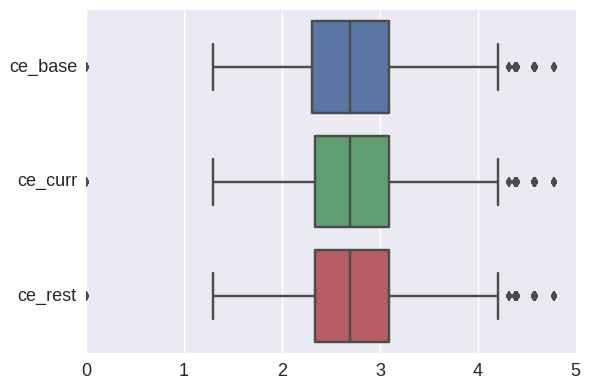

In [15]:
sns.boxplot(scenarios, orient='h')

### assign subregions to points:

In [23]:
subregions = gpd.read_file('/home/dmf/bahamas-mpa/cv/cv-fromjess/Bahamas_regionalCV_Inputs/LandPoly_Bahamas_subregions_v2.shp')

In [24]:
# buffer ensures the land polygons enclose the coastal points, which are a bit offshore
# for subregions as discontiguous islands, this is no big deal
# if subregions were contiguous areas whose buffers overlapped, that would be problematic
subregions['geometry'] = subregions.buffer(300) # native resolution of CV shorepoint raster is 250m 

In [25]:
list(subregions)

[u'CROSS_SHLF',
 u'Name',
 u'ORIG_FID',
 u'Subregion',
 'geometry',
 u'sq_meter',
 u'sqmeter_2']

In [26]:
# cleanup the subregions table a bit before joining it's attributes to points
subregions.drop(axis=1, labels=['CROSS_SHLF', 'ORIG_FID', 'Subregion', 'sq_meter', 'sqmeter_2'], inplace=True)

#### prep scenarios exposure table for spatial join with subregions

In [27]:
# we'll borrow point geometry from the original coastal_exposure.shp
pts_shp = gpd.read_file('../mpa-removeall-habitat/cv-output-invest3.3.0/outputs/coastal_exposure/coastal_exposure.shp')
pts_shp.crs

{'init': u'epsg:32618'}

In [28]:
scenarios['fid'] = scenarios.index
scenarios_shp = gpd.GeoDataFrame(scenarios, crs=pts_shp.crs, geometry=pts_shp.geometry)

In [29]:
pts_in_region = gpd.sjoin(scenarios_shp, subregions, how='inner', op='intersects')

In [30]:
# QAQC: did all points get 1 and only 1 subregion assignment?
len(pts_in_region) == len(scenarios)

True

In [31]:
# QAQC: if above was False, which points were assigned multiple regions?
# if above was True, this should return empty output
dups = pts_in_region.fid[pts_in_region.duplicated('fid')]
pts_in_region.loc[pts_in_region.fid.isin(dups)]

# if there are duplicated points
# either make assignments manually by dropping rows, or edit subregion shapefile/buffer in GIS 
# and repeat spatial join. I opted for latter.

,ce_base,ce_curr,ce_rest,fid,geometry,index_right,Name


In [32]:
pts_in_region.head()

,ce_base,ce_curr,ce_rest,fid,geometry,index_right,Name
0,2.336241,2.336241,2.336241,0,POINT (162996.410662489 3019659.244384566),16,Abaco
1,0.000000,0.000000,0.000000,1,POINT (162746.410662489 3019409.244384566),16,Abaco
2,2.336241,2.336241,2.336241,2,POINT (163246.410662489 3019409.244384566),16,Abaco
3,2.336241,2.336241,2.336241,3,POINT (163496.410662489 3019409.244384566),16,Abaco
4,2.336241,2.336241,2.336241,4,POINT (162746.410662489 3019159.244384566),16,Abaco


In [33]:
pts_in_region.drop(axis=1, labels='index_right', inplace=True)

In [ ]:
# pts_in_region['habrole'] = pts_in_region.ce_allhab - pts_in_region.ce_nompa

In [34]:
pts_in_region.to_file('../swmma-scenarios/ce_3scenarios_byisland.shp')

### Categorize exposure indices into high-med-low
using distribution of combined exposure values from multiple scenarios

In [35]:
pts_in_region = gpd.read_file('../swmma-scenarios/ce_3scenarios_byisland.shp')

In [36]:
pts_in_region.shape

(27263, 6)

In [37]:
# drop all subregions except New Providence, to analyze these SWMMA scenarios
pts_newprov = pts_in_region[pts_in_region.Name == 'New Providence']

In [38]:
pts_newprov.head()

,Name,ce_base,ce_curr,ce_rest,fid,geometry
16628,New Providence,2.448095,2.634081,2.634081,10868,POINT (271246.410662489 2778159.244384566)
16629,New Providence,2.448095,2.634081,2.634081,10869,POINT (271496.410662489 2778159.244384566)
16630,New Providence,2.352158,2.519110,2.519110,10882,POINT (270746.410662489 2777909.244384566)
16631,New Providence,2.352158,2.519110,2.519110,10883,POINT (270996.410662489 2777909.244384566)
16632,New Providence,2.210337,2.378260,2.378260,10884,POINT (271746.410662489 2777909.244384566)


In [39]:
# drop habrole because we don't want it's values in the distribution of exposure values
longdf = pd.melt(frame=pts_newprov, id_vars=['geometry', 'fid', 'Name'])
longdf.rename(columns={'value': 'coast_exp'}, inplace=True)

In [40]:
longdf.head()

,geometry,fid,Name,variable,coast_exp
0,POINT (271246.410662489 2778159.244384566),10868,New Providence,ce_base,2.448095
1,POINT (271496.410662489 2778159.244384566),10869,New Providence,ce_base,2.448095
2,POINT (270746.410662489 2777909.244384566),10882,New Providence,ce_base,2.352158
3,POINT (270996.410662489 2777909.244384566),10883,New Providence,ce_base,2.352158
4,POINT (271746.410662489 2777909.244384566),10884,New Providence,ce_base,2.210337


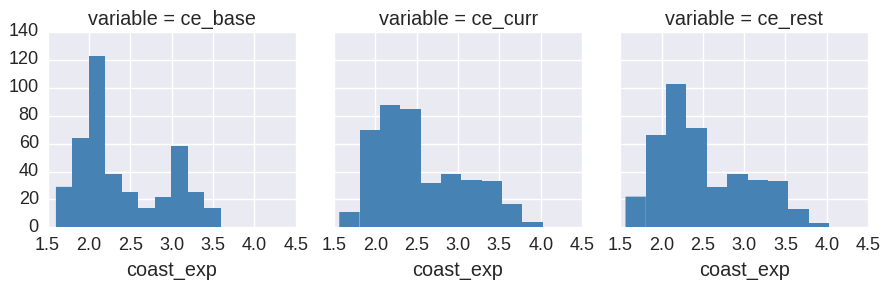

In [45]:
# combined coastal exposure distribution
# sns.distplot(longdf.coast_exp, kde=False, color='orange')
# sns.distplot(longdf.coast_exp, kde=False, color=longdf.variable)
g = sns.FacetGrid(longdf, col="variable", margin_titles=True)
g.map(plt.hist, "coast_exp", color="steelblue", lw=0)

#### choose cuts for high medium and low categories
low = bottom 25% of exposure values  
med = middle 50%  
high = top 25%  

In [46]:
quants = longdf.coast_exp.quantile([.25, .75])
print(quants)

0.25    2.072352
0.75    3.024871
Name: coast_exp, dtype: float64


In [47]:
def categorize_exposure(x):
    if x <= quants.iloc[0]:
        return 'low'
    if quants.iloc[0] < x < quants.iloc[1]:
        return 'med'
    if x >= quants.iloc[1]:
        return 'high'

In [48]:
longdf['category'] = longdf['coast_exp'].apply(func=categorize_exposure)

In [49]:
longdf.head()

,geometry,fid,Name,variable,coast_exp,category
0,POINT (271246.410662489 2778159.244384566),10868,New Providence,ce_base,2.448095,med
1,POINT (271496.410662489 2778159.244384566),10869,New Providence,ce_base,2.448095,med
2,POINT (270746.410662489 2777909.244384566),10882,New Providence,ce_base,2.352158,med
3,POINT (270996.410662489 2777909.244384566),10883,New Providence,ce_base,2.352158,med
4,POINT (271746.410662489 2777909.244384566),10884,New Providence,ce_base,2.210337,med


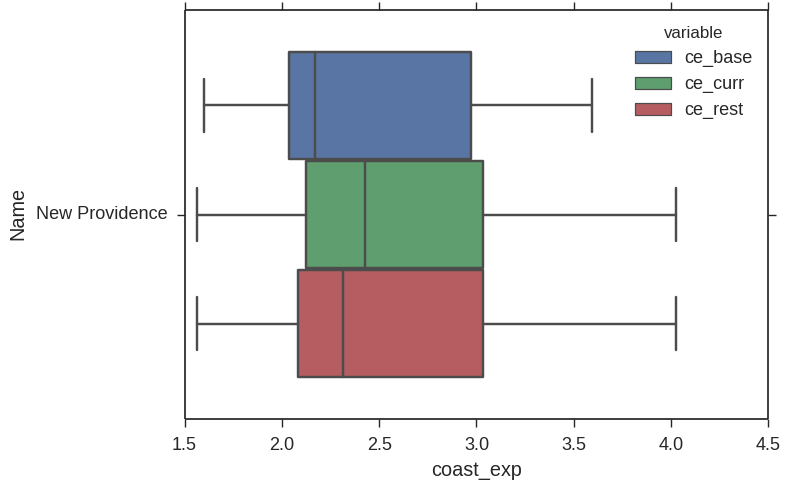

In [51]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.boxplot(x="coast_exp", y="Name", hue='variable', data=longdf)
fig.savefig('../swmma-scenarios/figs/cv_scenarios_boxplot_exposure.png')
fig.savefig('../swmma-scenarios/figs/cv_scenarios_boxplot_exposure.svg')

In [52]:
longdf.to_csv('../swmma-scenarios/cv_3scenarios_newprov_category.csv', index=False)

In [53]:
scenario_geo = gpd.GeoDataFrame(longdf, crs=pts_in_region.crs, geometry=longdf['geometry'])

In [54]:
scenario_geo.to_file('../swmma-scenarios/cv_3scenarios_newprov_category.shp')

### Metric 1: Length of coastline in each category, for each island  

In [ ]:
scenario_cat = pd.read_csv('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category.csv')

In [ ]:
scenario_cat.head()

In [ ]:
grouped_df = pd.DataFrame(scenario_cat.groupby(['Name', 'category', 'variable']).size().rename('npoints'))

In [ ]:
grouped_df.tail(15)

In [ ]:
coastlength = pd.DataFrame(grouped_df.to_records())

In [ ]:
coastlength.head(10)

In [ ]:
coastlength['km_shore'] = coastlength['npoints']*(0.25) # cv resolution was 250m

In [ ]:
coastlength.head()

In [ ]:
coastlength.to_csv('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category_kmshore.csv', index=False)

In [ ]:
# plot this scenario:
plotvar = 'ce_allhab'

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='km_shore', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=coastlength[coastlength.variable == plotvar])


fig.savefig('../figs/cv_shorelength_' + plotvar + '.png')
fig.savefig('../figs/cv_shorelength_' + plotvar + '.svg')

In [ ]:
# plot this scenario:
plotvar = 'ce_nompa'

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='km_shore', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=coastlength[coastlength.variable == plotvar])


fig.savefig('../figs/cv_shorelength_' + plotvar + '.png')
fig.savefig('../figs/cv_shorelength_' + plotvar + '.svg')

#### difference in km_shore between allhab and nompa scenarios

In [ ]:
coastlength = pd.read_csv('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category_kmshore.csv')

In [ ]:
# coastlength.head()
coastlength[coastlength.category == 'high']

In [ ]:
coastlength.drop(axis=1, labels='npoints', inplace=True)

In [ ]:
widecoast = coastlength.pivot_table(index=['Name', 'category'], columns='variable', values='km_shore')
widecoast.reset_index(inplace=True)

In [ ]:
widecoast.head()

In [ ]:
widecoast['diff_km'] = widecoast.ce_nompa - widecoast.ce_allhab

In [ ]:
widecoast.head()

In [ ]:
widecoast.to_csv('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category_diffkmshore.csv')

In [ ]:
# save a table...or just screenshot the one below
# widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high'].to_html('../figs/cv_shorelength_diff_nompa-allhab_table.html', index=False)

In [ ]:
widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high']

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
# cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diff_km', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high'])

ax.set(xlabel='change in km of shore at high exposure', 
       ylabel='', xlim=(0, 300))


fig.savefig('../figs/cv_shorelength_diff-high_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_shorelength_diff-high_nompa-allhab.svg)

In [ ]:
# def diff_km_shore(x):
#     try:
# #         print(len(x['km_shore']))
#         km_all = x['km_shore'][:1]
#         km_nompa = x['km_shore'][1:2]
#         print(km_all)
#         print(km_nompa)
#         return {x['Name'][:1]:km_all - km_nompa}
#     except(KeyError):
#         print('keyerr')

In [ ]:
# test = coastlength[coastlength.variable != 'ce_no_habi'].groupby(['Name', 'category']).apply(diff_km_shore)

### Metric 2: zonal stats for population metrics  

In [ ]:
scenario_geo = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category.shp')

#### now do the zonalstats

In [ ]:
import rasterstats as rs

In [ ]:
island_cats_geo = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_isl_cat_1kmbuf.shp', )

In [ ]:
def zonal_pop_stats(geodf, raster_path, prefix):
    pop_stats = rs.zonal_stats(geodf, raster_path, 
                           geojson_out=True, prefix=prefix,
                          stats=['sum'],
                          all_touched=True)
    pop_stats_gdf = gpd.GeoDataFrame.from_features(pop_stats)
    return pop_stats_gdf

In [ ]:
popdf = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/pop_int2.tif', 'pop_')
more65df = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/more65.tif', 'more65_')
incdf = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/totinc.tif', 'inc_')

In [ ]:
popdf.drop(axis=1, labels='value', inplace=True)

In [ ]:
incdf.head()

In [ ]:
popmetrics = pd.concat([popdf, more65df.more65_sum, incdf.inc_sum], axis=1)

In [ ]:
popmetrics.head()

In [ ]:
# pop_stats = rs.zonal_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/pop_int2.tif', 
#                            geojson_out=True, prefix='pop_',
#                           stats=['min', 'max', 'mean', 'sum', 'count'],
#                           all_touched=True)

In [ ]:
# pop_stats_gdf = gpd.GeoDataFrame.from_features(pop_stats)

In [ ]:
# pop_stats_gdf.head()

In [ ]:
def pivot_and_diff(x, valuestring):
    df = x[x.variable != 'ce_no_habi']
    wide = df.pivot_table(index=['Name', 'category'], columns='variable', values=valuestring)
    diffstr = 'diff' + valuestring
    wide[diffstr] = wide.ce_nompa_h - wide.ce_all_hab
    per_ch_str = 'per_ch_' + valuestring
    wide[per_ch_str] = (wide[diffstr]/wide.ce_all_hab)*100
    wide.reset_index(inplace=True)
#     print(wide.head())
    widehigh = wide[wide.category == 'high']
    return widehigh

In [ ]:
widepop = pivot_and_diff(popdf, 'pop_sum')
widemore65 = pivot_and_diff(more65df, 'more65_sum')
wideinc = pivot_and_diff(incdf, 'inc_sum')

In [ ]:
widepop.head()

In [ ]:
# widepop = popdf[popdf.variable != 'ce_no_habi'].pivot_table(index=['Name', 'category'], columns='variable', values='pop_sum')

In [ ]:
# widepop = popmetrics[popmetrics.variable != 'ce_no_habi'].pivot_table(index=['Name', 'category'], 
#                                                                       columns='variable', 
#                                                                       values=['pop_sum', 'more65_sum', 'inc_sum'])

In [ ]:
# widepop.head()

In [ ]:
# widepop['diff_pop'] = widepop.ce_nompa_h - widepop.ce_all_hab
# widepop['perch_pop'] = (widepop.diff_pop/widepop.ce_all_hab)*100

In [ ]:
# widepop.reset_index(inplace=True)

In [ ]:
# widepophigh = widepop[widepop.category == 'high']

In [ ]:
widepop

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
# cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])
sns.despine()

sns.barplot(y='Name', x='diffpop_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widepop)

ax.set(xlabel='change in population within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_population_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_population_diff_nompa-allhab.svg)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diffmore65_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widemore65)

ax.set(xlabel='change in pop (age > 65) within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_popover65_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_popover65_diff_nompa-allhab.svg', dpi=150)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diffinc_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=wideinc)

ax.set(xlabel='change in income within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_income_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_income_diff_nompa-allhab.svg)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diff_km', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=pop_stats_gdf)

ax.set(xlabel='change in km of shore', ylabel='',
      xlim=(-300, 300))

fig.savefig('../figs/cv_shorelength_diff_nompa-allhab.png')
fig.savefig('../figs/cv_shorelength_diff_nompa-allhab.svg')

In [ ]:
# put island levels on points
# put categories on points
# slice by island, then by category and
# buffer and dissolve points, calc zonal stats on the population rasters
# also want km of coastline (aka number of points) in each category, for each island


In [ ]:
scenarios.to_csv('../mpa-removeall-habitat/scenario_data/national_cv_3scenarios.csv')

In [ ]:
geo_df = gpd.GeoDataFrame(scenarios, crs=national_shp.crs, geometry=national_shp.geometry)

In [ ]:
geo_df.to_file('../mpa-removeall-habitat/scenario_data/national_cv_3scenarios.shp')

In [ ]:
# put the above code into a function that can work on each habitat,
# re-compute the coastal forest score after that
# re-compute habitat rank
# re-compute exposure index
# summarize change in EI by island
# summarize change in # of people by island